Question 1: Data Preprocessing (Medium)

a. Load the MNIST handwritten digit dataset and perform the following pre-processing steps: b. Normalize the pixel values of the images. c. Apply one-hot encoding to the target labels. d. Split the data into training, validation, and test sets. e. Dataset: https://github.com/iamavieira/handwritten-digits-mnist

In [4]:
!ls

sample_data		test-labels-idx1-ubyte	 train-labels-idx1-ubyte
test-images-idx3-ubyte	train-images-idx3-ubyte


In [5]:
# --- Imports ---
import numpy as np
import struct
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [6]:
# --- Load images ---
def load_images(path):
    with open(path, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        return images.reshape(num, rows, cols)

In [7]:
# --- Load labels ---
def load_labels(path):
    with open(path, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

In [11]:
# --- Load dataset ---
x_train = load_images("train-images-idx3-ubyte")
y_train = load_labels("train-labels-idx1-ubyte")
x_test  = load_images("test-images-idx3-ubyte")
y_test  = load_labels("test-labels-idx1-ubyte")


In [12]:
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42
)


In [13]:
# --- Output shapes ---
print("Training:", x_train.shape, y_train.shape)
print("Validation:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)

Training: (54000, 28, 28) (54000, 10)
Validation: (6000, 28, 28) (6000, 10)
Test: (10000, 28, 28) (10000, 10)


Question 2: Classification (Hard)

a. Build a logistic regression model to classify handwritten digits from the MNIST dataset. b. Evaluate the model performance using accuracy, precision, recall, and F1 score. c. Fine-tune the model hyperparameters using grid search CV to improve performance. d. Visualize the decision boundary of the model.

In [14]:
# ---------------- IMPORTS ----------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

In [15]:
import struct

# Load images
def load_images(path):
    with open(path, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        return images.reshape(num, rows, cols)

# Load labels
def load_labels(path):
    with open(path, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

# Dataset loading
x_train = load_images("train-images-idx3-ubyte")
y_train = load_labels("train-labels-idx1-ubyte")

x_test  = load_images("test-images-idx3-ubyte")
y_test  = load_labels("test-labels-idx1-ubyte")


In [16]:
from tensorflow.keras.utils import to_categorical

# Normalize pixel values
x_train = x_train / 255.0
x_test  = x_test / 255.0

# One-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test, num_classes=10)


In [17]:
# Flatten 28x28 → 784
X_train = x_train.reshape(x_train.shape[0], -1)
X_test  = x_test.reshape(x_test.shape[0], -1)

# Convert one-hot labels back to class labels
y_train_lbl = np.argmax(y_train, axis=1)
y_test_lbl  = np.argmax(y_test, axis=1)


In [18]:
# Small subset for faster computation
X_sub = X_train[:5000]
y_sub = y_train_lbl[:5000]


In [19]:
param_grid = {
    "C": [0.1, 1, 10]
}

grid = GridSearchCV(
    LogisticRegression(
        solver="saga",
        max_iter=300,
        n_jobs=-1
    ),
    param_grid,
    cv=2,
    scoring="accuracy"
)

grid.fit(X_sub, y_sub)

best_C = grid.best_params_["C"]
print("Best C:", best_C)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best C: 0.1


In [20]:
model = LogisticRegression(
    C=best_C,
    solver="saga",
    max_iter=300,
    n_jobs=-1
)

model.fit(X_sub, y_sub)
y_pred = model.predict(X_test)


In [21]:
print("Accuracy :", accuracy_score(y_test_lbl, y_pred))
print("Precision:", precision_score(y_test_lbl, y_pred, average="weighted"))
print("Recall   :", recall_score(y_test_lbl, y_pred, average="weighted"))
print("F1 Score :", f1_score(y_test_lbl, y_pred, average="weighted"))


Accuracy : 0.9036
Precision: 0.9034654178087148
Recall   : 0.9036
F1 Score : 0.9033145668165824


In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sub)


In [23]:
clf_2d = LogisticRegression(
    C=best_C,
    solver="saga",
    max_iter=300
)

clf_2d.fit(X_pca, y_sub)


LogisticRegression(C=0.1, max_iter=300, solver='saga')

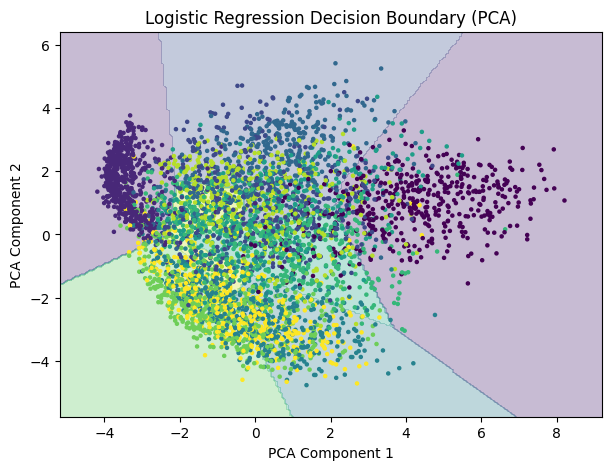

In [24]:
xx, yy = np.meshgrid(
    np.linspace(X_pca[:, 0].min()-1, X_pca[:, 0].max()+1, 200),
    np.linspace(X_pca[:, 1].min()-1, X_pca[:, 1].max()+1, 200)
)

Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,5))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sub, s=5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Logistic Regression Decision Boundary (PCA)")
plt.show()
